In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import torch
import clip
import yaml
from PIL import Image
from pathlib import Path
import pandas as pd
from IPython.display import display
from PIL.ImageDraw import ImageDraw
from tqdm.auto import tqdm
from figural.scoring import FiguralImage, FiguralScorer #get_zerosims, preprocess_imlist, image_loader, get_avg_sims, similarity_to_target
from figural.utils import autoset_device, grammar, collage, task_ref

In [172]:
device = autoset_device()
model, preprocess = clip.load("ViT-B/32", device=device)

# load test reference
with open('../../config.yaml') as f:
    data = yaml.safe_load(f)
root_dir = Path(data['root_dir'])
root_dir

CLIP doesn't work on M1 GPUs yet; check here for updates: https://github.com/openai/CLIP/issues/247


PosixPath('../..')

In [ ]:
# load all tasks and their scorers, and extract CLIP features now to save time later
loadedtasks = []

contrast_factor = 4
crop_bottom = False
for test in data['tests']:
    for task in test['tasks']:
        impaths = task_ref(root_dir / task['directory'])

        for activity, paths in tqdm(impaths.items(), desc=f'{test["name"]}/{task["name"]}', leave=False):
            if test['name'] == 'ttct':
                crop_options = [False, True]
            else:
                crop_options = [False]

            for crop_option in crop_options:
                scorer = FiguralScorer(paths, model, preprocess, device='cpu',
                                    contrast_factor=contrast_factor,
                                    crop_bottom=crop_option)
                scorer.get_image_features()

                loadedtasks.append(dict(
                    test = test['name'],
                    task = task['name'],
                    activity = activity,
                    blank = task['blanks'][activity],
                    paths = paths,
                    scorer = scorer,
                    crop_bottom = crop_option,
                    contrast_factor = contrast_factor
                ))

## Testing CLIP 

In [ ]:
i = 24
print(i)
impath = impaths['activity2a'][i]
display(FiguralImage(impath).contrast(3).im, FiguralImage(impath).contrast(3).crop(0.85).im)

## Brief Inspection of zero-shot quality

Look at it both with and without cropping.

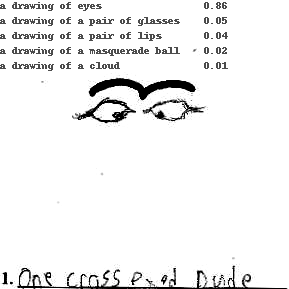

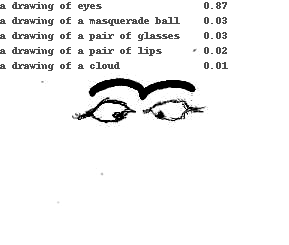

In [16]:
pil_inputs = [FiguralImage(impath).contrast(3).im, FiguralImage(impath).contrast(3).crop(0.85).im]
image_inputs = preprocess_imlist(pil_inputs, preprocess, device=device)

labels = ["a bird", "a girl", "a dog", "a cat", "eyes", "a sunset", "a heart", "love", "a cherry", "a cloud",
"a pair of glasses", "the sky", "a boy", "a flock of birds", "a pair of lips", "a flock of seagulls", "Toby", "a bikini", "a bone",
"a cartoon snake", "a masquerade ball", "a broken heart", "a cartoon man", "a man", "a book", "ice cream", "a pizza", "a cartoon pizza",
"a Ninja Turtle", "an ant", "a flower"]
# notes:
# 'cartoon snake' works better than 'snake'; try for many options
labels = [f"a drawing of {x}" for x in labels]
#labels = ["a broken heart", "a drawing of a broken heart", "a drawing of a cartoon broken heart", "a cartoon broken heart"]
text = clip.tokenize(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_inputs)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image_inputs, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for j, im in enumerate(pil_inputs):
    probs_s = pd.Series(probs[j], index=labels).round(2).sort_values(ascending=False)
    plaintxt = probs_s.head(5).__repr__()[::-1].split('\n', 1)[1][::-1]
    a = im.copy()
    draw = ImageDraw(a)
    draw.text((0,0), plaintxt, fill='Red')
    display(a)

## Scoring Method 1 - Average Similarity

Take similarity of each known image to each other, and see an average similarity. The idea being - high avg similarity means your response look a great deal like past responses.

In [144]:
simscollector = []
for loadedtask in loadedtasks:
    meta = dict(test=loadedtask['test'], task=loadedtask['booklet'], activity=loadedtask['activity'])
    sims = loadedtask['scorer'].get_avg_sims()
    for k,v in meta.items():
        sims[k] = v
    simscollector.append(sims)
simsdf = pd.concat(simscollector)
simsdf.to_csv(root_dir / 'data/metrics/avg_sim.csv', index=False)
simsdf.sample(4)

,path,avg_sim,id,contrast_factor,crop_bottom,test,task,activity
227,../../data/outputs/bookleta/activity2g/68332-7...,0.795856,68332-71596_Unmatched,4,False,ttct,bookleta,activity2g
394,../../../../data/others/audra/drawings/primary...,0.814260,5032_9,4,False,audra,primary,Images_9
427,../../data/outputs/bookletb/activity2g/67682-7...,0.818713,67682-74664,4,False,ttct,bookletb,activity2g
634,../../../../data/others/audra/drawings/primary...,0.808682,10531_56,4,False,audra,primary,Images_56


In [142]:
simsdf.rename(columns={'booklet':'task'}).to_csv(root_dir / 'data/metrics/elaboration.csv', index=False)

,path,avg_sim,id,contrast_factor,crop_bottom,test,task,activity
0,../../data/outputs/bookleta/activity2b/94fd1-7...,0.815490,94fd1-71561,4,False,ttct,bookleta,activity2b
1,../../data/outputs/bookleta/activity2b/9cf64-7...,0.687476,9cf64-79099,4,False,ttct,bookleta,activity2b
2,../../data/outputs/bookleta/activity2b/c6e72-7...,0.800683,c6e72-74881,4,False,ttct,bookleta,activity2b
3,../../data/outputs/bookleta/activity2b/94fd1-7...,0.718740,94fd1-70694,4,False,ttct,bookleta,activity2b
4,../../data/outputs/bookleta/activity2b/d9583-6...,0.729815,d9583-66934,4,False,ttct,bookleta,activity2b
...,...,...,...,...,...,...,...,...
92,../../../../data/others/audra/drawings/far_gen...,0.818520,O7_217,4,False,audra,far,Images_7
93,../../../../data/others/audra/drawings/far_gen...,0.863745,O7_50,4,False,audra,far,Images_7
94,../../../../data/others/audra/drawings/far_gen...,0.809434,O7_44,4,False,audra,far,Images_7
95,../../../../data/others/audra/drawings/far_gen...,0.810280,O7_363,4,False,audra,far,Images_7


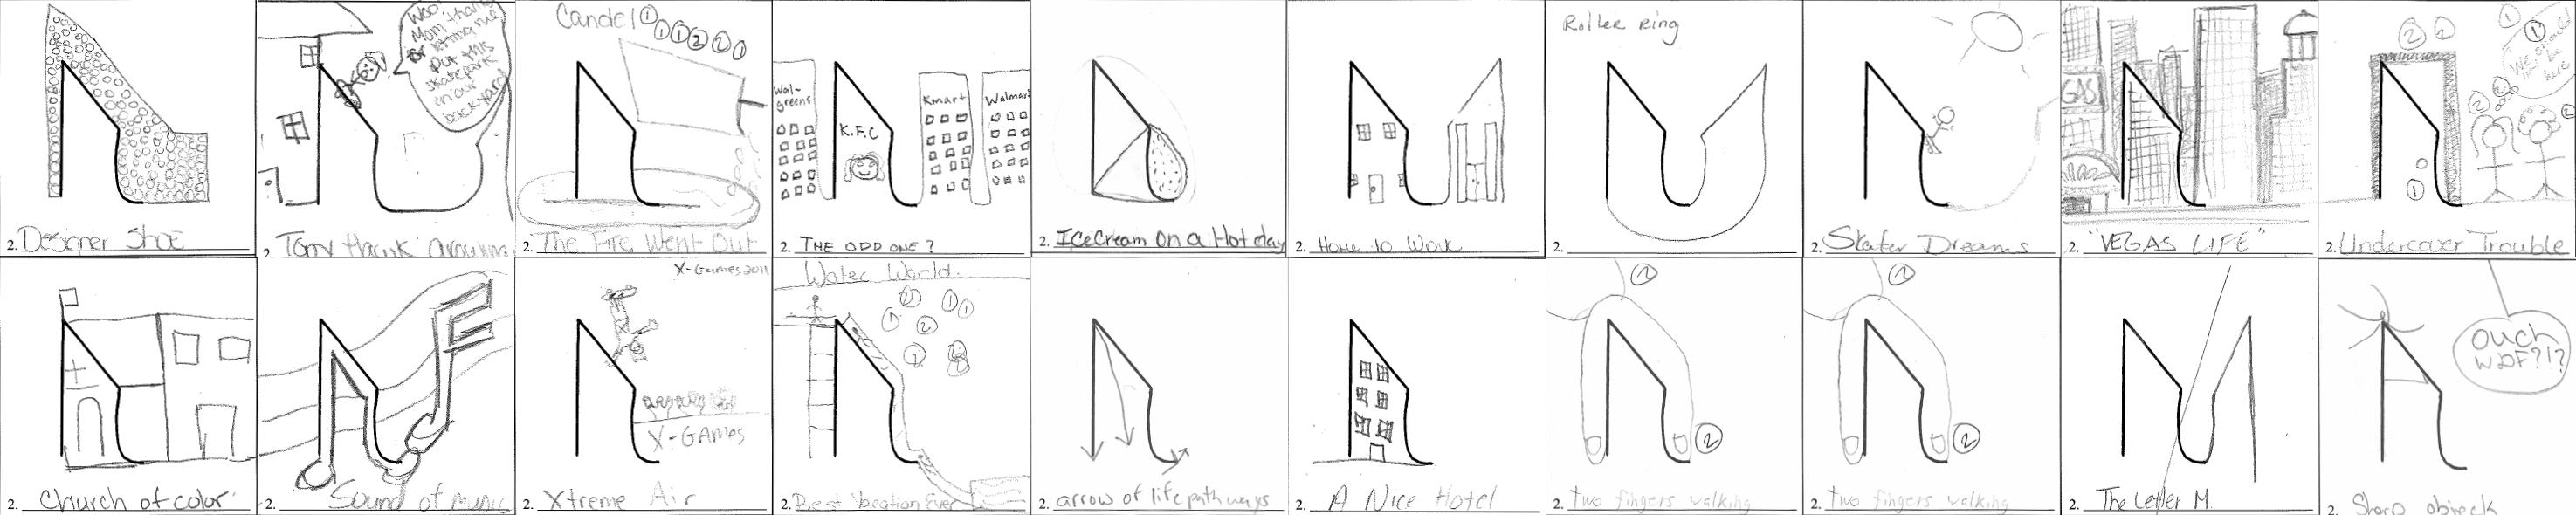

In [124]:
most_original = collage(simsdf.query('activity == "activity2b" and booklet == "bookletb"').sort_values('avg_sim').path.tolist(), cols=10, rows=2) # don't specify rows to show *all*
most_original

## Scoring Method 2 - Similarity to blank

In [188]:
simscollector = []
for loadedtask in loadedtasks:
    meta = dict(test=loadedtask['test'], task=loadedtask['task'], activity=loadedtask['activity'])
    sims = loadedtask['scorer'].get_sims_to_target(loadedtask['blank'])
    for k,v in meta.items():
        sims[k] = v
    simscollector.append(sims)
simsdf = pd.concat(simscollector)
simsdf.to_csv(root_dir / 'data/metrics/blank_sim.csv', index=False)
simsdf.sample(4)

,path,blank_sim,id,contrast_factor,crop_bottom,test,task,activity
207,../../data/outputs/bookleta/activity2g/6dcd4-1...,0.777317,6dcd4-1603,4,True,ttct,bookleta,activity2g
179,../../data/outputs/bookletb/activity2f/ae4f2-7...,0.838177,ae4f2-7183,4,True,ttct,bookletb,activity2f
301,../../data/outputs/bookletb/activity2c/6678b-7...,0.890868,6678b-75288,4,True,ttct,bookletb,activity2c
322,../../../../data/others/audra/drawings/primary...,0.777392,5044_9,4,False,audra,primary,Images_9


## Scoring Method 3 - Similarity to Zero List

This is not relevant to MTCI.

TODO where is zero-list for booklet A

In [194]:
zero_list = pd.read_csv(data_dir/'zero_list.csv')
zero_list['zero_term'] = zero_list.zero_term.apply(grammar)
zero_list[['test', 'task']] = 'ttct', 'bookleta'
zero_list.sample()

,activity,zero_term,zero_term2,test,task
90,activity2i,a duck,a duck,ttct,bookleta


True

In [237]:
zterm_template = "sketch of {}"

simscollector = []
for loadedtask in loadedtasks:
    subset = zero_list
    for col in ['test', 'task', 'activity']:
        subset = subset[subset[col] == loadedtask[col]]
    if subset.empty:
        continue
    zero_terms = subset.zero_term2.tolist()
    if zterm_template.strip():
        zero_terms = [zterm_template.format(x) for x in zero_terms]

    meta = dict(test=loadedtask['test'], task=loadedtask['task'], activity=loadedtask['activity'])
    sims = loadedtask['scorer'].get_zerosims(zero_terms)
    for k,v in meta.items():
        sims[k] = v
    simscollector.append(sims)
simsdf = pd.concat(simscollector)
simsdf.to_csv(root_dir / 'data/metrics/zero_sim.csv', index=False)
simsdf.sample(4)

,path,min_zlist,mean_zlist,lowest3_zlist,id,contrast_factor,crop_bottom,test,task,activity
428,../../data/outputs/bookleta/activity2e/781e5-7...,0.261533,0.278187,0.264409,781e5-79194,4,False,ttct,bookleta,activity2e
190,../../data/outputs/bookleta/activity2h/9b50a-7...,0.219007,0.256045,0.229039,9b50a-75096,4,True,ttct,bookleta,activity2h
255,../../data/outputs/bookleta/activity1/406e2-19...,0.217171,0.237394,0.227764,406e2-19836,4,False,ttct,bookleta,activity1
130,../../data/outputs/bookleta/activity2g/65a68-6...,0.211581,0.245648,0.223118,65a68-67706,4,False,ttct,bookleta,activity2g


In [240]:
test = pd.read_parquet(root_dir / 'data' / f"zlist_sims_sketch_of.parquet")
test.sample()

,path,min_zlist,mean_zlist,lowest3_zlist,booklet,activity,cropped,contrast,id
444,../../data/outputs/bookleta/activity2j/4f5cb-7...,0.225381,0.253411,0.235185,BOOKLETA,activity2j,False,4,4f5cb-76184


## Combine outputs

Save to CSV for sharing with others.

In [257]:
data_dir = root_dir / 'data/metrics'
blanksim = pd.read_csv(data_dir / 'blank_sim.csv')
avgsim = pd.read_csv(data_dir / 'avg_sim.csv')
elab = pd.read_csv(data_dir / 'elaboration.csv')
zlist = pd.read_csv(data_dir / 'zero_sim.csv')
combined = blanksim.merge(avgsim).merge(zlist).merge(elab)
combined.to_csv(data_dir / 'all_data.csv')

## Calculate Cronbach's alpha

In [352]:
import pingouin

def feature_ablation_alpha(df, score_col):
    '''Calculate full Cronbach's alpha, as well as how much removing a specific item changes it'''
    fullalpha, ci = pingouin.cronbach_alpha(df, items='activity', scores=score_col, subject='id')
    print(f"Full Alpha: {fullalpha:.4f}")
    itemcols = combined['activity'].sort_values().unique()
    for exclude_item in itemcols:
        subset = df[df.activity != exclude_item]
        alpha, ci = pingouin.cronbach_alpha(subset, items='activity', scores=score_col, subject='id')
        diff = alpha-fullalpha
        diffsign = '+' if diff > 0 else '-'
        print(f"\tw/o {exclude_item}:\t{alpha:.4f} ({diffsign}{abs(diff):.4f})")

In [378]:
q = 0.2
for q in np.arange(0.00, 0.25, 0.05):
    print(f"Elab {q:.02f} quantile: {combined.elaboration.quantile(q):.4f}")

    excluding_blank = combined[combined.elaboration > combined.elaboration.quantile(q)]
    for metric in ['elaboration', 'avg_sim', 'blank_sim']:
        alpha, ci = pingouin.cronbach_alpha(excluding_blank, items='activity', scores=metric, subject='id')
        print(f"\t{metric}:\t{alpha:.4f}")

Elab 0.00 quantile: 0.0000
	elaboration:	0.7486
	avg_sim:	0.5762
	blank_sim:	0.6398
Elab 0.05 quantile: 0.0010
	elaboration:	0.7589
	avg_sim:	0.5927
	blank_sim:	0.6124
Elab 0.10 quantile: 0.0041
	elaboration:	0.7724
	avg_sim:	0.6130
	blank_sim:	0.6305
Elab 0.15 quantile: 0.0088
	elaboration:	0.7736
	avg_sim:	0.6192
	blank_sim:	0.6444
Elab 0.20 quantile: 0.0128
	elaboration:	0.7657
	avg_sim:	0.6105
	blank_sim:	0.6106


In [353]:
for metric in ['elaboration', 'avg_sim', 'blank_sim']:
    print(metric.upper().center(25, '-'))
    feature_ablation_alpha(combined, metric)

-------ELABORATION-------
Full Alpha: 0.7488
	w/o activity1:	0.7275 (-0.0213)
	w/o activity2a:	0.7306 (-0.0182)
	w/o activity2b:	0.7389 (-0.0099)
	w/o activity2c:	0.7285 (-0.0203)
	w/o activity2d:	0.7290 (-0.0198)
	w/o activity2e:	0.7329 (-0.0159)
	w/o activity2f:	0.7329 (-0.0159)
	w/o activity2g:	0.7258 (-0.0230)
	w/o activity2h:	0.7307 (-0.0181)
	w/o activity2i:	0.7226 (-0.0262)
	w/o activity2j:	0.7350 (-0.0138)
---------AVG_SIM---------
Full Alpha: 0.5719
	w/o activity1:	0.5537 (-0.0182)
	w/o activity2a:	0.5332 (-0.0387)
	w/o activity2b:	0.5538 (-0.0180)
	w/o activity2c:	0.5401 (-0.0317)
	w/o activity2d:	0.5483 (-0.0236)
	w/o activity2e:	0.5488 (-0.0230)
	w/o activity2f:	0.5368 (-0.0350)
	w/o activity2g:	0.5381 (-0.0337)
	w/o activity2h:	0.5534 (-0.0184)
	w/o activity2i:	0.5744 (+0.0025)
	w/o activity2j:	0.5499 (-0.0219)
--------BLANK_SIM--------
Full Alpha: 0.6442
	w/o activity1:	0.6264 (-0.0178)
	w/o activity2a:	0.6291 (-0.0151)
	w/o activity2b:	0.6406 (-0.0036)
	w/o activity2c:	0

In [140]:
data['tests'][0]['tasks']

[{'name': 'bookleta',
  'directory': 'data/outputs/bookleta',
  'blanks': [{'activity1': 'data/outputs/bookleta/activity1/6771d-70668.jpg'},
   {'activity2a': 'data/outputs/bookleta/activity2a/3ee42-68082-UM.jpg'},
   {'activity2b': 'data/outputs/bookleta/activity2b/39dc2-73297.jpg'},
   {'activity2c': 'data/outputs/bookleta/activity2c/b238c-77873.jpg'},
   {'activity2d': 'data/outputs/bookleta/activity2d/9cf64-76063.jpg'},
   {'activity2e': 'data/outputs/bookleta/activity2e/9cf64-75262.jpg'},
   {'activity2f': 'data/outputs/bookleta/activity2f/b560a-74943_Unmatched.jpg'},
   {'activity2g': 'data/outputs/bookleta/activity2g/dbfa7-78460.jpg'},
   {'activity2h': 'data/outputs/bookleta/activity2h/21ac7-62874.jpg'},
   {'activity2i': 'data/outputs/bookleta/activity2i/dbfa7-78460.jpg'},
   {'activity2j': 'data/outputs/bookleta/activity2j/b238c-77751.jpg'}]},
 {'name': 'bookletb', 'directory': 'data/outputs/bookletb'}]